In [118]:
### LIBRARY
import os
import glob
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage.io import imsave
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum, threshold_isodata, threshold_triangle, threshold_mean
from skimage.filters import threshold_otsu, threshold_li, threshold_yen
from skimage.morphology import binary_erosion, binary_dilation
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_dilation
from scipy.spatial.distance import cdist

from statistics import mean, stdev
import re
from natsort import natsorted

In [190]:
### PARAMETERS
filename = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Images_from_Felipe/Macrophages_and_ECs/ImmEpis_EXP6_d16_GFP_cTnT_CD31'
# filename extract
last_folder = os.path.basename(filename)
# output folder:
output_folder = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/Images_from_Felipe'


# to save masks:
folder = f'{filename}/masks'
os.makedirs(folder, exist_ok=True)

print(last_folder)

pixel_size = 0.65

ImmEpis_EXP6_d16_GFP_cTnT_CD31


In [191]:
### LOADING

## DAPI in 405 channel:
list_of_dapi_files = natsorted(glob.glob(f"{filename}/*ch00*.tif"))
images_dapi = {}
for file in list_of_dapi_files:
    img = io.imread(file)
    images_dapi[os.path.basename(file)] = img

## 488 channel:
list_of_488_files = natsorted(glob.glob(f"{filename}/*ch01*.tif"))
images_488 = {}
for file in list_of_488_files:
    img = io.imread(file)
    images_488[os.path.basename(file)] = img

## 594 channel:
list_of_594_files = natsorted(glob.glob(f"{filename}/*ch02*.tif"))
images_594 = {}
for file in list_of_594_files:
    img = io.imread(file)
    images_594[os.path.basename(file)] = img

## 647 channel:
list_of_647_files = natsorted(glob.glob(f"{filename}/*ch03*.tif"))
images_647 = {}
for file in list_of_647_files:
    img = io.imread(file)
    images_647[os.path.basename(file)] = img

print(f"to check: \n number of 405 images: \t {len(images_dapi)}, \n number of 488 images: \t {len(images_488)},"
      f"\n number of 594 images: \t {len(images_594)}, \n number of 647 images: \t {len(images_647)}")

to check: 
 number of 405 images: 	 6, 
 number of 488 images: 	 6,
 number of 594 images: 	 6, 
 number of 647 images: 	 6


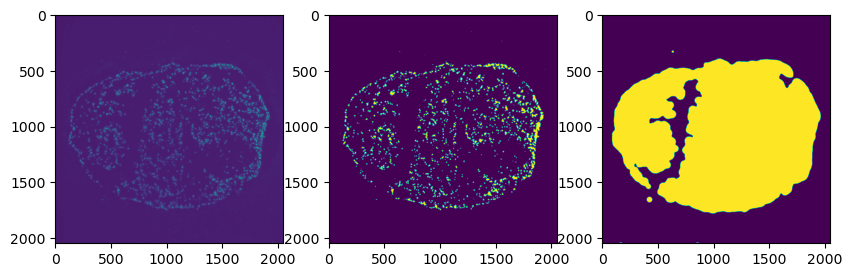

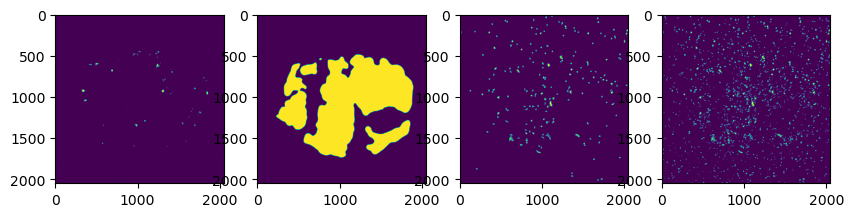

In [204]:
# ### PARAMETERS testing

tested_image = 'Image 10'

## testing:
# tries all automatic thresholding options for the image 
# fig, ax = try_all_threshold(blurred_dapi_test, figsize=(6, 12), verbose=False)
# plt.show()

## DAPI/organoid area:
image_dapi_test = images_dapi[f'{tested_image}_ch00.tif']
blurred_dapi_test = gaussian(image_dapi_test, sigma=1) #blurs the nuclei together, sigma determines the blurring
image_thresholded = blurred_dapi_test > threshold_otsu(blurred_dapi_test) # try triangle or mean
image_thresholded_2 = remove_small_holes(image_thresholded, area_threshold=800000) #800000
blurred_dapi_v2 = gaussian(image_thresholded_2, sigma=17)
image_thresholded_3 = blurred_dapi_v2 > threshold_triangle(blurred_dapi_v2)
image_thresholded_2 = remove_small_holes(image_thresholded_3, area_threshold=200000)

fig, axs = plt.subplots(ncols=3, figsize=(10,7))
axs[0].imshow(image_dapi_test)
axs[1].imshow(image_thresholded)
axs[2].imshow(image_thresholded_2)


## 488
image_488_test = images_488[f'{tested_image}_ch01.tif']
thresholded_488_test = (image_488_test > threshold_otsu(image_488_test))

## 594
image_594_test = images_594[f'{tested_image}_ch02.tif']
size_exc_594_test = remove_small_objects(image_594_test, min_size=100)
blurred_594_test = gaussian(size_exc_594_test, sigma=25)
thresholded_594_1_test = blurred_594_test > threshold_li(blurred_594_test)
thresholded_594_2_test = remove_small_holes(thresholded_594_1_test, area_threshold=100000)


## 647
image_647_test = images_647[f'{tested_image}_ch03.tif']
thresholded_647_test = image_647_test > threshold_triangle(image_647_test)
thresholded_647_2_test = remove_small_objects(thresholded_647_test, min_size=150)


fig, axs = plt.subplots(ncols=4, figsize=(10,7))
axs[0].imshow(thresholded_488_test)
axs[1].imshow(thresholded_594_2_test)
axs[2].imshow(thresholded_647_2_test)
axs[3].imshow(thresholded_647_test)


In [205]:
### Individual image analysis (based on the test image from above)

#overal signal/percentage of are of all channels
individual_organoid_size = np.sum(image_thresholded_2)
individual_organoid_size_in_um = individual_organoid_size*(pixel_size**2)

individual_488_signal = np.sum(thresholded_488_test & image_thresholded_2)
individual_per_488 = individual_488_signal/individual_organoid_size

individual_594_signal = np.sum(thresholded_594_2_test & image_thresholded_2)
individual_594_in_um = individual_594_signal*(pixel_size**2)
individual_per_594 = individual_594_signal/individual_organoid_size

individual_647_signal = np.sum(thresholded_647_2_test & image_thresholded_2)
individual_647_per = individual_647_signal/individual_organoid_size

# calculations:
individual_epicardium = image_thresholded_2 & (~thresholded_594_2_test)
individual_epi_size = individual_organoid_size - individual_594_signal
individual_epi_size_in_um = individual_epi_size*(pixel_size**2)
individual_epicardium_area_per = individual_epi_size/individual_organoid_size

## creation of buffer zone/CD31 calc.
individual_dilated_epi = binary_dilation(individual_epicardium, disk(50))
individual_buffer_zone = thresholded_594_2_test & individual_dilated_epi
individual_CD31_in_buffer = thresholded_647_2_test & individual_buffer_zone
individualCD31_in_buffer_sum = np.sum(individual_CD31_in_buffer)
individual_CD31_in_buffer_per = individualCD31_in_buffer_sum/individual_647_signal

individual_CD31_in_cTnT = np.sum(thresholded_594_2_test & thresholded_647_2_test)

individual_CD31_per_in_cTnT = individual_CD31_in_cTnT/individual_647_signal - individual_CD31_in_buffer_per

individual_CD31_not_in_cTNT = thresholded_647_2_test & (~thresholded_594_2_test)
individual_CD31_in_epicardium = np.sum(individual_CD31_not_in_cTNT)
individual_CD31_per_in_epicardium = individual_CD31_in_epicardium/individual_647_signal

## macs calc.
individual_GFP_in_buffer = np.sum(thresholded_488_test & individual_buffer_zone)
individual_GFP_in_buffer_per = individual_GFP_in_buffer/individual_488_signal

individual_GFP_in_cTnT = np.sum(thresholded_594_2_test & thresholded_488_test)
individual_GFP_per_in_cTnT = individual_GFP_in_cTnT/individual_488_signal - individual_GFP_in_buffer_per

individual_GFP_not_in_cTNT = thresholded_488_test & (~thresholded_594_2_test)
individual_GFP_in_epicardium = np.sum(individual_GFP_not_in_cTNT)
individual_GFP_per_in_epicardium = individual_GFP_in_epicardium/individual_488_signal


# image mask:
R = (
    thresholded_594_2_test.astype(np.uint8) * 255 +  # Red from Magenta
    thresholded_647_2_test.astype(np.uint8) * 255    # Red from Yellow
)
G = (
    thresholded_488_test.astype(np.uint8) * 255 +  # Green from Green
    thresholded_647_2_test.astype(np.uint8) * 255 +   # Green from Yellow
    individual_buffer_zone.astype(np.uint8) * 255
)
B = (
    image_thresholded_2.astype(np.uint8) * 255 +  # Blue from Blue
    thresholded_594_2_test.astype(np.uint8) * 255 +   # Blue from Magenta
    individual_buffer_zone.astype(np.uint8) * 255
)
# Stack into RGB
rgb_image = np.stack([R, G, B], axis=-1)
# Clip values to stay within valid 8-bit range
rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

image_filename = f'{tested_image}.png'
filepath = os.path.join(folder, image_filename)
plt.imsave(filepath, rgb_image)

Individual_image_data = {
        'organoid area': individual_organoid_size,
        'organoid area in um': individual_organoid_size_in_um,
        'myocardium area': individual_594_signal,
        'myocardium area in um': individual_594_in_um,
        'myocardium area per': individual_per_594,
        'epicardium area': individual_epi_size,
        'epicardium area in um': individual_epi_size_in_um,
        'epicardium area per': individual_epicardium_area_per,
        'CD31 area': individual_647_per,
        'GFP area': individual_per_488,
        'macs in epicardium per': individual_GFP_per_in_epicardium,
        'macs in myocardium per': individual_GFP_per_in_cTnT,
        'macs in buffer zone per': individual_GFP_in_buffer_per,
        'CD31 in epicardium per': individual_CD31_per_in_epicardium,
        'CD31 in myocardium per': individual_CD31_per_in_cTnT,
        'CD31 in buffer zone per': individual_CD31_in_buffer_per
    }

df_individual_image_data = pd.DataFrame.from_dict(Individual_image_data, orient='index')
print(tested_image)
print(df_individual_image_data.T)

Image 10
   organoid area  organoid area in um  myocardium area  myocardium area in um  \
0      1886710.0           797134.975        1140003.0            481651.2675   

   myocardium area per  epicardium area  epicardium area in um  \
0             0.604228         746707.0            315483.7075   

   epicardium area per  CD31 area  GFP area  macs in epicardium per  \
0             0.395772   0.018565  0.003779                0.281666   

   macs in myocardium per  macs in buffer zone per  CD31 in epicardium per  \
0                0.375929                 0.344649                0.460188   

   CD31 in myocardium per  CD31 in buffer zone per  
0                0.562052                 0.364576  


In [163]:
### Analysis
Image_data_CD31_files = {}

for name,img in images_dapi.items():

    ## DAPI
    dapi_gaussian_blurred = gaussian(img, sigma=35)
    thresholded_405 = dapi_gaussian_blurred > threshold_triangle(dapi_gaussian_blurred)
    thresholded_405_2 = remove_small_holes(thresholded_405, area_threshold=800000)
    organoid_size = np.sum(thresholded_405_2)
    organoid_size_in_um = organoid_size*(pixel_size**2)

    #image name extracted:
    name_without_last_part = '_'.join(name.split('_')[:-1]) # splits the ch__ from the name, so that
                                                              # the script can get the relevant images 
                                                              # from other channels

    ## 488
    img_488 = images_488[f'{name_without_last_part}_ch01.tif']
    thresholded_488_origin = img_488 > threshold_otsu(img_488) # are of macs before filtering by DAPI
    thresholded_488 = (img_488 > threshold_otsu(img_488)) & thresholded_405_2
    overal_488_signal = np.sum(thresholded_488) # records overal 488 area

    if overal_488_signal == 0:
        overal_488_signal = np.nan

    ## 594
    img_594 = images_594[f'{name_without_last_part}_ch02.tif']
    image_trash_removal = remove_small_objects(img_594, min_size=300)
    blurred_594 = gaussian(image_trash_removal, sigma=20)
    thresholded_594_1 = blurred_594 > threshold_li(blurred_594)
    thresholded_594_2 = remove_small_holes(thresholded_594_1, area_threshold=800000)
    cTnT_594_area = np.sum(thresholded_594_2)
    cTnT_594_area_in_um = cTnT_594_area*(pixel_size**2)
    cTnT_per = cTnT_594_area/organoid_size

    ## 647
    img_647 = images_647[f'{name_without_last_part}_ch03.tif']
    thresholded_647 = img_647 > threshold_triangle(img_647)
    thresholded_647_2 = remove_small_objects(thresholded_647, min_size=150) & thresholded_405_2
    overal_647_signal = np.sum(thresholded_647_2)

    if overal_647_signal == 0:
        overal_647_signal = np.nan

    ## calculations:
    epicardium = thresholded_405 & (~thresholded_594_2)
    epicardium_size = organoid_size - cTnT_594_area
    epicardium_size_in_um = epicardium_size*(pixel_size**2)
    epicardium_area_per = epicardium_size/organoid_size
    if epicardium_size <0:
        print(f"The DAPI/cTnT measurement for image {name_without_last_part} is wrong")

    CD31_area = overal_647_signal/organoid_size
    macs_area = overal_488_signal/organoid_size
    
    ## are CD31+ in epicardium or myocardium?

    # creating a 'buffer zone' in myocardium that is neighbouring the epicardium
    dilated_epicardium = binary_dilation(epicardium, disk(50))
    buffer_zone = thresholded_594_2 & dilated_epicardium
    CD31_in_buffer = thresholded_647_2 & buffer_zone
    CD31_in_buffer_sum = np.sum(CD31_in_buffer)
    if CD31_in_buffer_sum==0:
        CD31_in_buffer_sum = np.nan
    else:
        CD31_in_buffer_per = CD31_in_buffer_sum/overal_647_signal

    # CD31 in myocardium:
    CD31_in_cTnT = np.sum(thresholded_594_2 & thresholded_647_2) # what is the overlap area

    if CD31_in_cTnT==0:
        CD31_per_in_cTnT = np.nan
        print(f'no CD31+ cells in myocardium of {name_without_last_part}')
    else:
        CD31_per_in_cTnT = CD31_in_cTnT/overal_647_signal - CD31_in_buffer_per
    
    # CD31 in epicardium
    CD31_not_in_cTNT = thresholded_647_2 & (~thresholded_594_2)
    CD31_in_epicardium = np.sum(CD31_not_in_cTNT)
    if CD31_in_epicardium==0:
        CD31_per_in_epicardium = np.nan
        print(f'no CD31+ cells in epicardium of {name_without_last_part}')
    else:
        CD31_per_in_epicardium = CD31_in_epicardium/overal_647_signal

    ## are GFP+ in epicardium or myocardium?

    # GFP in buffer zone (e.g. myocardium neighbouring epicardium)
    GFP_in_buffer = np.sum(thresholded_488 & buffer_zone)
    if GFP_in_buffer==0:
        GFP_in_buffer_per = np.nan
    else:
        GFP_in_buffer_per = GFP_in_buffer/overal_488_signal

    # GFP in myocardium:
    GFP_in_cTnT = np.sum(thresholded_594_2 & thresholded_488) # what is the overlap area
    if GFP_in_cTnT==0:
        print(f'no macs in myocardium of {name_without_last_part}')
        GFP_per_in_cTnT = np.nan
    else:
        GFP_per_in_cTnT = GFP_in_cTnT/overal_488_signal - GFP_in_buffer_per
    
    # GFP in epicardium
    GFP_not_in_cTNT = thresholded_488 & (~thresholded_594_2) #what is the area outside of the overlap
    GFP_in_epicardium = np.sum(GFP_not_in_cTNT)
    if GFP_in_epicardium==0:
        print(f'no macs in epicardium of {name_without_last_part}')
        GFP_per_in_epicardium = np.nan
    else:
        GFP_per_in_epicardium = GFP_in_epicardium/overal_488_signal

    # image mask:
    R = (
        thresholded_594_2.astype(np.uint8) * 255 +  # Red from Magenta
        thresholded_647_2.astype(np.uint8) * 255    # Red from Yellow
    )
    G = (
        thresholded_488.astype(np.uint8) * 255 +  # Green from Green
        thresholded_647_2.astype(np.uint8) * 255 +   # Green from Yellow
        buffer_zone.astype(np.uint8) * 255
    )
    B = (
        thresholded_405_2.astype(np.uint8) * 255 +  # Blue from Blue
        thresholded_594_2.astype(np.uint8) * 255 +   # Blue from Magenta
        buffer_zone.astype(np.uint8) * 255
    )
    # Stack into RGB
    rgb_image = np.stack([R, G, B], axis=-1)
    # Clip values to stay within valid 8-bit range
    rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

    image_filename = f'{name_without_last_part}.png'
    filepath = os.path.join(folder, image_filename)
    plt.imsave(filepath, rgb_image)

    # image data
    Image_data_CD31_files[name_without_last_part] = {
        'organoid area': organoid_size,
        'organoid area in um': organoid_size_in_um,
        'myocardium area': cTnT_594_area,
        'myocardium area in um': cTnT_594_area_in_um,
        'myocardium area per': cTnT_per,
        'epicardium area': epicardium_size,
        'epicardium area in um': epicardium_size_in_um,
        'epicardium area per': epicardium_area_per,
        'CD31 area': CD31_area,
        'GFP area': macs_area,
        'macs in epicardium per': GFP_per_in_epicardium,
        'macs in myocardium per': GFP_per_in_cTnT,
        'macs in buffer zone per': GFP_in_buffer_per,
        'CD31 in epicardium per': CD31_per_in_epicardium,
        'CD31 in myocardium per': CD31_per_in_cTnT,
        'CD31 in buffer zone per': CD31_in_buffer_per
    }

#NOTE: the buffer zone is part of the myocardium zone. All the CD31 recorded in buffer zone are therefore
#      also counted as part of the myocardium x but also, myocardium zone is created by gaussian blurring
#      which makes the area artificially bigger. Therefore, buffer is in myocardium technically, but 
#      that might not be the case in the real image
#      on the other hand, I reduced the amount of blurring for the latest version of this script
#      which might have made the myocardium much more accurate

#NOTE: I put 'remove small holes' function in the DAPI channel thresholding. It makes the organoid
#      size measurement less accurate (because it masks tears and cavities and whatnot), but it 
#      makes up for the dimming of signal in some images

#NOTE: the CD31 channel has a ton of specks (mainly for EXP7), that are clearly not a real signal, 
#      which I removed using 'remove small objects' function. It could get rid of some of the 
#      signal as well...

#NOTE: I could also try to count the number of macrophages by counting the number of nuclei present in
#      the signal. But for that I would need more accurate nuclei mask... (not blurred one). Maybe
#      it would be worth it to experiment with machine learning models for this one? Or better thresholding
#      but also its fluorescent image, not confocal and the nuclei can be from cardiomyocytes


In [155]:
### DATAFRAME
df_stain1 = pd.DataFrame.from_dict(Image_data_CD31_files, orient='index')

output_path = f'{output_folder}/{last_folder}.xlsx'
df_stain1.to_excel(output_path)

